# Notebook pour l'utilisation de BERT en Transfert Learning

### 1 - Importation des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
data = pd.read_csv("scrapping_script/donnees_labelisees_3600.csv")
data

,Id,Titre,Label
0,c49811e444b22ae37862b9416ba7cecc.html,Photographie,culture
1,e74b3feeb31ad56e50e62ba0e7ccf2bd.html,"Exposition ""Big Bang"" à Paris : dans le viseur...",culture
2,2ca19e391db2716ea8748588ffd5fc8d.html,Angelina Jolie,culture
3,ea9de8015b2609a21a6507c515936685.html,"Jeu vidéo : Nintendo opère un ""virage à 180 de...",culture
4,58ad0fe71d3b09ce13ce9a6a1125ec12.html,Jeux Vidéo,culture
...,...,...,...
3596,6deb216324a566856c8fdc6d4ad3dced.html,Canoë-Kayak,sports
3597,266eddd46824d5df3376c2530bcb748c.html,Vendée Globe 2024 : Sam Goodchild reprend la t...,sports
3598,c15688fc7a0dadc81d54da557db6a5db.html,Mondiaux de cyclisme sur piste,sports
3599,9f9f0764a852634a4f115bb790acdccd.html,Ligue des champions : revivez la défaite en to...,sports


In [3]:
label_map = {"culture" :  0, "monde": 1, "meteo": 2, "sante": 3, "politique": 4, "societe": 5, "europe": 6, "environnement": 7, "sports": 8}
inv_label_map = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe", 6: "europe", 7: "environnement", 8: "sports"}
inv_label_map_to_keep = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe"}

# Conversion des étiquettes en indices numériques
labels_numeric = [label_map[label] for label in data['Label']]
print(len(labels_numeric))

3601


### 2-a - Importation du modèle

In [4]:
# from transformers import BertTokenizer,BertForSequenceClassification

# model_name = 'distilbert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# max_len = 128
# encodings = tokenizer(data['Titre'].astype(str).tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='pt')
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9)

In [5]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification

model_name = 'camembert-base'
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name, num_labels=9)

max_len = 128
encodings = tokenizer(data['Titre'].astype(str).tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='pt')


/home/gris/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 19:00:26.855993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 19:00:26.948309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733335226.987902    5449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733335226.998748    5449 cuda_blas.cc:1418] Unable t

### 2-b Preprocessing des données

In [6]:
def preprocess_texts(texts, blacklist_words, remove_random=False, random_fraction=0.1):
   
    cleaned_texts = []
    
    for text in texts:
        words = text.split()
        words = [word for word in words if word.lower() not in blacklist_words]
        
        if remove_random:
            num_to_remove = int(len(words) * random_fraction)
            words = [word for i, word in enumerate(words) if i not in random.sample(range(len(words)), num_to_remove)]
        
        cleaned_texts.append(' '.join(words))
    
    return cleaned_texts


# Exemple d'utilisation
blacklist_words = ["le", "la", "les", "un", "une", "et", "ou","l'","il"] 

# Nettoyer les titres
data['Titre_preprocess'] = preprocess_texts(
    data['Titre'].astype(str).tolist(), 
    blacklist_words=blacklist_words, 
    remove_random=True,  
    random_fraction=0.1
)


### 3 - Découpage des données

In [9]:
from sklearn.model_selection import train_test_split


train_texts, test_texts, train_labels, test_labels = train_test_split(data['Titre_preprocess'].astype(str).tolist(), labels_numeric,
                                                                      test_size=0.1, random_state=42)
train_texts, validation_texts, train_labels, validation_labels = train_test_split(train_texts, train_labels,
                                                                                  test_size=0.2, random_state=42)


train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')

test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')


validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')


In [10]:
import torch

train_input_ids = train_encodings['input_ids']
train_attention_masks = train_encodings['attention_mask']
train_labels_tensor = torch.tensor(train_labels)

test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']
test_labels_tensor = torch.tensor(test_labels)

In [11]:
validation_input_ids = validation_encodings['input_ids']
validation_attention_masks = validation_encodings['attention_mask']
validation_labels_tensor = torch.tensor(validation_labels)


### 4 - Entrainement du modèle

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Convertir les labels en tensor
train_labels_tensor = torch.tensor(train_labels)
validation_labels_tensor = torch.tensor(validation_labels)
test_labels_tensor = torch.tensor(test_labels)


# Créer des TensorDatasets pour l'entraînement et la validation
train_dataset = TensorDataset(
    train_encodings['input_ids'], 
    train_encodings['attention_mask'], 
    train_labels_tensor
)

validation_dataset = TensorDataset(
    validation_encodings['input_ids'], 
    validation_encodings['attention_mask'], 
    validation_labels_tensor
)

test_dataset = TensorDataset(
    test_encodings['input_ids'], 
    test_encodings['attention_mask'], 
    test_labels_tensor
)

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)


In [14]:
import torch
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Vérification de l'availability du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Déplacer le modèle sur le GPU si disponible
model.to(device)

#Congeler les premières couches du modèle
for param in model.base_model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# Vérifier les paramètres avant d'exécuter le code
for name, param in model.named_parameters():
    if 'classifier' in name:  # Vérifier spécifiquement les paramètres de la couche classifier
        print(f"Nom : {name}, requires_grad : {param.requires_grad}")

cuda
Nom : classifier.dense.weight, requires_grad : True
Nom : classifier.dense.bias, requires_grad : True
Nom : classifier.out_proj.weight, requires_grad : True
Nom : classifier.out_proj.bias, requires_grad : True


/home/gris/miniforge3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.80batch/s]


Epoch [1/80], Train Loss: 2.1810, Validation Loss: 2.1572


Epoch 2/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.79batch/s]


Epoch [2/80], Train Loss: 2.1402, Validation Loss: 2.1153


Epoch 3/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.75batch/s]


Epoch [3/80], Train Loss: 2.0991, Validation Loss: 2.0735


Epoch 4/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.73batch/s]


Epoch [4/80], Train Loss: 2.0520, Validation Loss: 2.0276


Epoch 5/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.81batch/s]


Epoch [5/80], Train Loss: 2.0063, Validation Loss: 1.9779


Epoch 6/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.65batch/s]


Epoch [6/80], Train Loss: 1.9541, Validation Loss: 1.9242


Epoch 7/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.63batch/s]


Epoch [7/80], Train Loss: 1.8970, Validation Loss: 1.8700


Epoch 8/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.81batch/s]


Epoch [8/80], Train Loss: 1.8496, Validation Loss: 1.8087


Epoch 9/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.80batch/s]


Epoch [9/80], Train Loss: 1.7878, Validation Loss: 1.7493


Epoch 10/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.76batch/s]


Epoch [10/80], Train Loss: 1.7325, Validation Loss: 1.6876


Epoch 11/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.74batch/s]


Epoch [11/80], Train Loss: 1.6789, Validation Loss: 1.6273


Epoch 12/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.73batch/s]


Epoch [12/80], Train Loss: 1.6146, Validation Loss: 1.5690


Epoch 13/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.71batch/s]


Epoch [13/80], Train Loss: 1.5533, Validation Loss: 1.5075


Epoch 14/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.72batch/s]


Epoch [14/80], Train Loss: 1.5148, Validation Loss: 1.4534


Epoch 15/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.67batch/s]


Epoch [15/80], Train Loss: 1.4687, Validation Loss: 1.4011


Epoch 16/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.70batch/s]


Epoch [16/80], Train Loss: 1.4122, Validation Loss: 1.3548


Epoch 17/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.73batch/s]


Epoch [17/80], Train Loss: 1.3747, Validation Loss: 1.3056


Epoch 18/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.84batch/s]


Epoch [18/80], Train Loss: 1.3416, Validation Loss: 1.2682


Epoch 19/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.77batch/s]


Epoch [19/80], Train Loss: 1.2880, Validation Loss: 1.2244


Epoch 20/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.66batch/s]


Epoch [20/80], Train Loss: 1.2692, Validation Loss: 1.1914


Epoch 21/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.72batch/s]


Epoch [21/80], Train Loss: 1.2310, Validation Loss: 1.1586


Epoch 22/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.74batch/s]


Epoch [22/80], Train Loss: 1.2055, Validation Loss: 1.1260


Epoch 23/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.66batch/s]


Epoch [23/80], Train Loss: 1.1713, Validation Loss: 1.0958


Epoch 24/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.69batch/s]


Epoch [24/80], Train Loss: 1.1618, Validation Loss: 1.0746


Epoch 25/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.74batch/s]


Epoch [25/80], Train Loss: 1.1302, Validation Loss: 1.0473


Epoch 26/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.68batch/s]


Epoch [26/80], Train Loss: 1.1176, Validation Loss: 1.0292


Epoch 27/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.64batch/s]


Epoch [27/80], Train Loss: 1.1075, Validation Loss: 1.0046


Epoch 28/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.66batch/s]


Epoch [28/80], Train Loss: 1.0897, Validation Loss: 0.9893


Epoch 29/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.63batch/s]


Epoch [29/80], Train Loss: 1.0642, Validation Loss: 0.9708


Epoch 30/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.67batch/s]


Epoch [30/80], Train Loss: 1.0456, Validation Loss: 0.9616


Epoch 31/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.71batch/s]


Epoch [31/80], Train Loss: 1.0307, Validation Loss: 0.9369


Epoch 32/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.73batch/s]


Epoch [32/80], Train Loss: 1.0343, Validation Loss: 0.9246


Epoch 33/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.74batch/s]


Epoch [33/80], Train Loss: 1.0078, Validation Loss: 0.9172


Epoch 34/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.72batch/s]


Epoch [34/80], Train Loss: 1.0126, Validation Loss: 0.9029


Epoch 35/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.72batch/s]


Epoch [35/80], Train Loss: 0.9938, Validation Loss: 0.8900


Epoch 36/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.70batch/s]


Epoch [36/80], Train Loss: 0.9952, Validation Loss: 0.8770


Epoch 37/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.84batch/s]


Epoch [37/80], Train Loss: 0.9689, Validation Loss: 0.8662


Epoch 38/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.57batch/s]


Epoch [38/80], Train Loss: 0.9697, Validation Loss: 0.8607


Epoch 39/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.81batch/s]


Epoch [39/80], Train Loss: 0.9308, Validation Loss: 0.8456


Epoch 40/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.65batch/s]


Epoch [40/80], Train Loss: 0.9624, Validation Loss: 0.8356


Epoch 41/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.81batch/s]


Epoch [41/80], Train Loss: 0.9325, Validation Loss: 0.8291


Epoch 42/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.81batch/s]


Epoch [42/80], Train Loss: 0.9314, Validation Loss: 0.8192


Epoch 43/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.59batch/s]


Epoch [43/80], Train Loss: 0.9220, Validation Loss: 0.8131


Epoch 44/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.80batch/s]


Epoch [44/80], Train Loss: 0.9153, Validation Loss: 0.8004


Epoch 45/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.74batch/s]


Epoch [45/80], Train Loss: 0.9106, Validation Loss: 0.7981


Epoch 46/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.61batch/s]


Epoch [46/80], Train Loss: 0.8979, Validation Loss: 0.7874


Epoch 47/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.69batch/s]


Epoch [47/80], Train Loss: 0.9011, Validation Loss: 0.7849


Epoch 48/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.71batch/s]


Epoch [48/80], Train Loss: 0.8724, Validation Loss: 0.7741


Epoch 49/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.58batch/s]


Epoch [49/80], Train Loss: 0.8937, Validation Loss: 0.7690


Epoch 50/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.78batch/s]


Epoch [50/80], Train Loss: 0.8702, Validation Loss: 0.7624


Epoch 51/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.69batch/s]


Epoch [51/80], Train Loss: 0.8783, Validation Loss: 0.7548


Epoch 52/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.82batch/s]


Epoch [52/80], Train Loss: 0.8866, Validation Loss: 0.7573


Epoch 53/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.67batch/s]


Epoch [53/80], Train Loss: 0.8829, Validation Loss: 0.7503


Epoch 54/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.63batch/s]


Epoch [54/80], Train Loss: 0.8837, Validation Loss: 0.7388


Epoch 55/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.64batch/s]


Epoch [55/80], Train Loss: 0.8779, Validation Loss: 0.7388


Epoch 56/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.79batch/s]


Epoch [56/80], Train Loss: 0.8530, Validation Loss: 0.7373


Epoch 57/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.68batch/s]


Epoch [57/80], Train Loss: 0.8455, Validation Loss: 0.7340


Epoch 58/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.68batch/s]


Epoch [58/80], Train Loss: 0.8396, Validation Loss: 0.7308


Epoch 59/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.76batch/s]


Epoch [59/80], Train Loss: 0.8413, Validation Loss: 0.7225


Epoch 60/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.75batch/s]


Epoch [60/80], Train Loss: 0.8207, Validation Loss: 0.7246


Epoch 61/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.73batch/s]


Epoch [61/80], Train Loss: 0.8374, Validation Loss: 0.7138


Epoch 62/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.66batch/s]


Epoch [62/80], Train Loss: 0.8496, Validation Loss: 0.7181


Epoch 63/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.74batch/s]


Epoch [63/80], Train Loss: 0.8349, Validation Loss: 0.7100


Epoch 64/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.68batch/s]


Epoch [64/80], Train Loss: 0.8046, Validation Loss: 0.7039


Epoch 65/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.70batch/s]


Epoch [65/80], Train Loss: 0.8208, Validation Loss: 0.7023


Epoch 66/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.61batch/s]


Epoch [66/80], Train Loss: 0.8105, Validation Loss: 0.6999


Epoch 67/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.67batch/s]


Epoch [67/80], Train Loss: 0.8220, Validation Loss: 0.6995


Epoch 68/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.79batch/s]


Epoch [68/80], Train Loss: 0.8244, Validation Loss: 0.6932


Epoch 69/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.58batch/s]


Epoch [69/80], Train Loss: 0.7808, Validation Loss: 0.6941


Epoch 70/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.70batch/s]


Epoch [70/80], Train Loss: 0.7994, Validation Loss: 0.6911


Epoch 71/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.75batch/s]


Epoch [71/80], Train Loss: 0.8113, Validation Loss: 0.6847


Epoch 72/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.69batch/s]


Epoch [72/80], Train Loss: 0.8032, Validation Loss: 0.6826


Epoch 73/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.79batch/s]


Epoch [73/80], Train Loss: 0.7711, Validation Loss: 0.6807


Epoch 74/80 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.14batch/s]


Epoch [74/80], Train Loss: 0.8167, Validation Loss: 0.6790


Epoch 75/80 - Validation: 100%|██████████| 6/6 [00:04<00:00,  1.47batch/s]


Epoch [75/80], Train Loss: 0.8007, Validation Loss: 0.6787


Epoch 76/80 - Validation: 100%|██████████| 6/6 [00:04<00:00,  1.48batch/s]


Epoch [76/80], Train Loss: 0.8004, Validation Loss: 0.6697


Epoch 77/80 - Validation: 100%|██████████| 6/6 [00:04<00:00,  1.46batch/s]


Epoch [77/80], Train Loss: 0.7807, Validation Loss: 0.6723


Epoch 78/80 - Validation: 100%|██████████| 6/6 [00:04<00:00,  1.47batch/s]


Epoch [78/80], Train Loss: 0.7698, Validation Loss: 0.6697


Epoch 79/80 - Validation: 100%|██████████| 6/6 [00:04<00:00,  1.48batch/s]


Epoch [79/80], Train Loss: 0.7972, Validation Loss: 0.6670


Epoch 80/80 - Validation: 100%|██████████| 6/6 [00:04<00:00,  1.47batch/s]

Epoch [80/80], Train Loss: 0.7776, Validation Loss: 0.6615


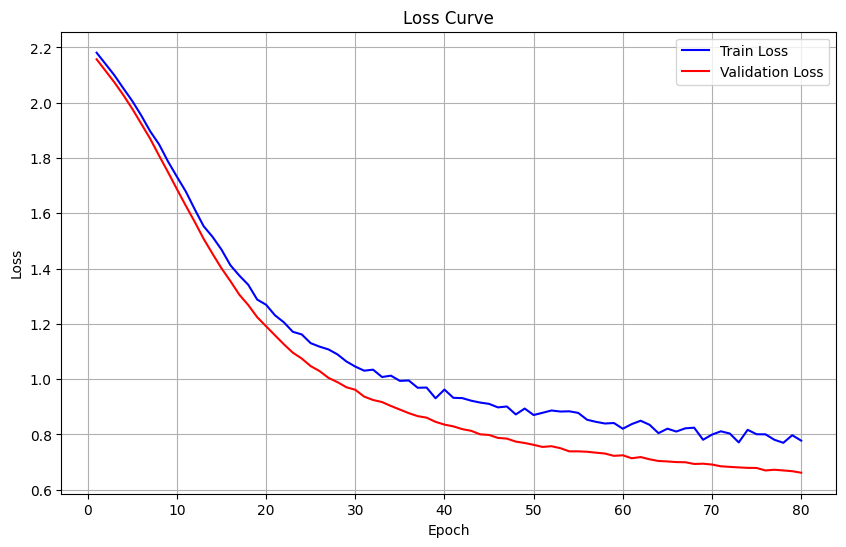

In [15]:
# Optimiseur
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1)

# Mode entraînement
model.train()

# Variables pour stocker les pertes
train_losses = []
val_losses = []

# Nombre d'époques
nb_epoch = 80

# Boucle d'entraînement
for epoch in range(nb_epoch):
    # Phase d'entraînement
    model.train()
    total_train_loss = 0
    
    # Utilisation de tqdm pour la barre de progression
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{nb_epoch} - Training", unit="batch"):
        input_ids, attention_mask, labels = batch
        
        # Déplacer les données sur le GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        # Propagation avant (forward pass)
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
        # La perte est automatiquement calculée par le modèle avec CrossEntropyLoss
        loss = outputs.loss
        
        # Rétropropagation (backpropagation)
        loss.backward()
        
        # Optimisation des paramètres du modèle
        optimizer.step()
        optimizer.zero_grad()
        
        # Ajouter la perte de ce batch à la perte totale
        total_train_loss += loss.item()

    # Calcul de la perte moyenne pour l'entraînement
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase de validation
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():  # Désactive la rétropropagation pour économiser de la mémoire
        # Utilisation de tqdm pour la barre de progression pendant la validation
        for batch in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{nb_epoch} - Validation", unit="batch"):
            input_ids, attention_mask, labels = batch
            
            # Déplacer les données sur le GPU
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            # Propagation avant (forward pass)
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                            labels=labels)
            
            # La perte de validation
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    # Calcul de la perte moyenne pour la validation
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    
    # Affichage de la perte de validation
    print(f"Epoch [{epoch+1}/{nb_epoch}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, nb_epoch + 1), val_losses, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Répertoire où sauvegarder le modèle
save_directory = "./saved_model"

# Sauvegarder le modèle
model.save_pretrained(save_directory)

# Sauvegarder le tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Modèle et tokenizer enregistrés dans le répertoire {save_directory}")


Modèle et tokenizer enregistrés dans le répertoire ./saved_model


### 5 - Validation du modèle

Validation Loss: 0.5811261137326559


<Figure size 2000x2000 with 0 Axes>

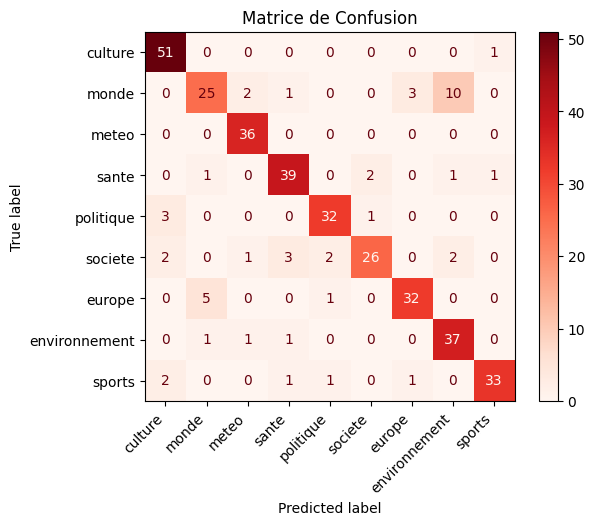

In [16]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

all_predictions = []
all_labels = []

test_loss = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels = batch

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
    test_loss += outputs.loss.item()

    predictions = torch.argmax(outputs.logits, dim=1)
    
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_dataloader)
print(f"Validation Loss: {test_loss}")

all_labels_name = [inv_label_map[x] for x in all_labels]
all_predictions_name = [inv_label_map[x] for x in all_predictions]

cm = confusion_matrix(all_labels, all_predictions)

# Assurez-vous que le nombre d'étiquettes ici correspond à vos 9 labels dans inv_label_map
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[inv_label_map[i] for i in range(9)])
plt.figure(figsize=(20, 20))
display.plot(cmap=plt.cm.Reds)
plt.title("Matrice de Confusion")
plt.xticks(rotation=45, ha="right")
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score

def calculate_metrics(labels, predictions):
    metrics = {}
    metrics['accuracy'] = accuracy_score(labels, predictions)
    metrics['precision'] = precision_score(labels, predictions, average='weighted')
    metrics['recall'] = recall_score(labels, predictions, average='weighted')
    metrics['f0.5_score'] = fbeta_score(labels, predictions, beta=0.5, average='weighted')
    metrics['f2_score'] = fbeta_score(labels, predictions, beta=2, average='weighted')
    metrics['f1_score'] = fbeta_score(labels, predictions, beta=1, average='weighted')
    
    return metrics

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt

def calculate_classwise_metrics(labels, predictions):
    
    metrics_per_class = {}
    
    for class_index, class_name in inv_label_map.items():
        class_labels = [1 if label == class_index else 0 for label in labels]
        class_predictions = [1 if pred == class_index else 0 for pred in predictions]
        
        metrics_per_class[class_name] = {
            'accuracy': accuracy_score(class_labels, class_predictions),
            'precision': precision_score(class_labels, class_predictions, zero_division=0),
            'recall': recall_score(class_labels, class_predictions, zero_division=0),
            'f1_score': fbeta_score(class_labels, class_predictions, beta=1, zero_division=0),
            'f0.5_score': fbeta_score(class_labels, class_predictions, beta=0.5, zero_division=0),
            'f2_score': fbeta_score(class_labels, class_predictions, beta=2, zero_division=0)
        }
    
    return metrics_per_class

def display_classwise_metrics(metrics_per_class):
    
    class_names = list(metrics_per_class.keys())
    metric_names = ['accuracy', 'precision', 'recall', 'f1_score', 'f0.5_score', 'f2_score']
    
    donnees = np.array([[metrics_per_class[cls][metric] for metric in metric_names] for cls in class_names])
    num_classes, num_metrics = donnees.shape
    
    x = np.arange(num_metrics) 
    width = 0.15 
    fig, ax = plt.subplots(figsize=(12, 7))  # Taille ajustée pour 9 classes
    
    for i in range(num_classes):
        ax.bar(x + i * width, donnees[i], width, label=class_names[i])
    
    ax.set_title("Métriques par Classe", fontsize=16)
    ax.set_xticks(x + width * (num_classes - 1) / 2)
    ax.set_xticklabels(metric_names, fontsize=12)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_ylim(0, 1)  
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


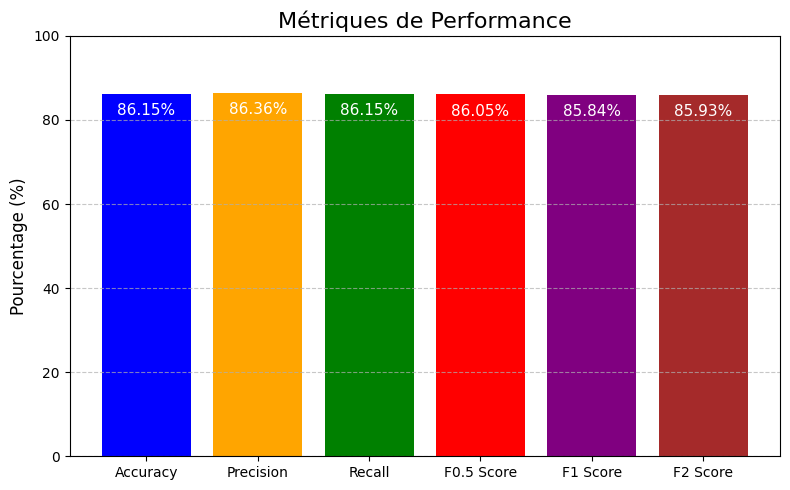

In [19]:
metrics = calculate_metrics(all_labels, all_predictions)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F0.5 Score', 'F1 Score', 'F2 Score']
metric_values = [
    metrics['accuracy'] * 100,
    metrics['precision'] * 100,
    metrics['recall'] * 100,
    metrics['f0.5_score'] * 100,
    metrics['f1_score'] * 100,
    metrics['f2_score'] * 100
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5,
             f"{value:.2f}%", ha='center', color='white', fontsize=11)

plt.title("Métriques de Performance", fontsize=16)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

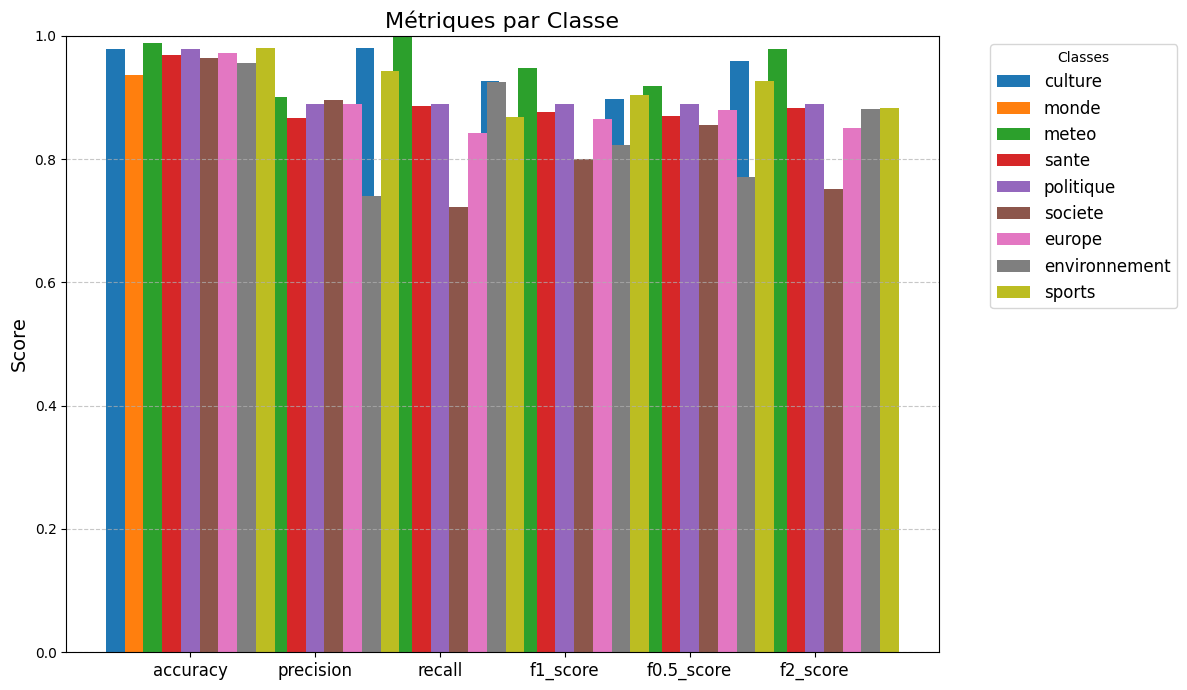

In [20]:
display_classwise_metrics(calculate_classwise_metrics(all_labels, all_predictions))